In [15]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers

C:\Users\JM\AppData\Local\Temp\ipykernel_8572\664724195.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\JM\AppData\Local\Temp\ipykernel_8572\664724195.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\JM\AppData\Local\Temp\ipykernel_8572\664724195.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\JM\AppData\Local\Temp\ipykernel_8572\664724195.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be r

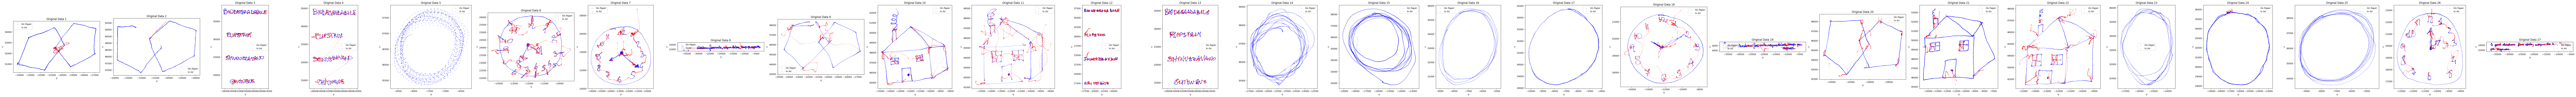

In [16]:

# Data Preprocessing Function to Load All Files from a Specific Folder
def load_and_process_files_from_folder(folder_path, num_files_to_use=None):
    # Get all files in the folder
    all_files = glob.glob(os.path.join(folder_path, '*'))
    if num_files_to_use:
        all_files = all_files[:num_files_to_use]  # Limit the number of files if specified

    data_frames = []
    original_data_frames = []
    scalers = []
    input_filenames = []
    original_absolute_files = []

    num_files = len(all_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6 * num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    output_folder = os.path.join('model', 'original_absolute')
    os.makedirs(output_folder, exist_ok=True)

    for i, file_path in enumerate(all_files):
        filename = os.path.basename(file_path)
        input_filenames.append(filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        save_path = os.path.join(output_folder, filename)
        original_absolute_files.append(save_path)
        df.to_csv(save_path, sep=' ', index=False, header=False)

        original_data_frames.append(df.copy())
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]]
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames, original_absolute_files

# Example usage:
folder_path = "../test/samplefew"
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames, original_absolute_files = load_and_process_files_from_folder(folder_path)


In [18]:
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Function to pad sequences
def pad_sequences(sequences):
    # Convert list of numpy arrays to list of tensors
    tensor_sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
    
    # Pad all sequences to the same length
    padded_sequences = pad_sequence(tensor_sequences, batch_first=True)
    
    # Get the lengths of each sequence (before padding)
    lengths = torch.tensor([len(seq) for seq in tensor_sequences])
    
    return padded_sequences, lengths


In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

# Encoder (VAE)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        # Reshape input to combine batch and sequence length for linear layers
        batch_size, seq_len, input_dim = x.size()
        x = x.view(-1, input_dim)  # Flatten input to shape (batch_size * seq_len, input_dim)
        
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        # Reshape the output back to (batch_size, seq_len, latent_dim)
        mu = mu.view(batch_size, seq_len, -1)
        logvar = logvar.view(batch_size, seq_len, -1)
        
        return mu, logvar

# Decoder (VAE)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, z):
        # Reshape input to combine batch and sequence length for linear layers
        batch_size, seq_len, latent_dim = z.size()
        z = z.view(-1, latent_dim)  # Flatten input to shape (batch_size * seq_len, latent_dim)
        
        h = torch.relu(self.fc1(z))
        recon_x = torch.sigmoid(self.fc2(h))
        
        # Reshape the output back to (batch_size, seq_len, output_dim)
        recon_x = recon_x.view(batch_size, seq_len, -1)
        
        return recon_x

# Discriminator (GAN)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Reshape input to combine batch and sequence length for linear layers
        batch_size, seq_len, input_dim = x.size()
        x = x.view(-1, input_dim)  # Flatten input to shape (batch_size * seq_len, input_dim)
        
        h = torch.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        
        # Reshape the output back to (batch_size, seq_len, 1)
        out = out.view(batch_size, seq_len, 1)
        
        return out

# VAE-GAN Model
class VAEGAN(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAEGAN, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.discriminator = Discriminator(input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, lengths):
        # Unpack padded sequence
        x_unpacked, _ = pad_packed_sequence(x, batch_first=True)

        # Forward pass through VAE
        mu, logvar = self.encoder(x_unpacked)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)

        # Pack the output back to maintain padded sequence structure
        packed_recon_x = pack_padded_sequence(recon_x, lengths, batch_first=True, enforce_sorted=False)
        return packed_recon_x, mu, logvar

# Loss Functions
def vae_loss(recon_x, x, mu, logvar):
    x_unpacked, _ = pad_packed_sequence(x, batch_first=True)
    recon_unpacked, _ = pad_packed_sequence(recon_x, batch_first=True)
    recon_loss = nn.functional.mse_loss(recon_unpacked, x_unpacked, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

def gan_loss(real_data, fake_data, discriminator):
    real_loss = nn.functional.binary_cross_entropy(discriminator(real_data), torch.ones_like(discriminator(real_data)))
    fake_loss = nn.functional.binary_cross_entropy(discriminator(fake_data), torch.zeros_like(discriminator(fake_data)))
    return real_loss + fake_loss

# Training Loop with Packed Sequences
def train_vaegan(model, dataloader, num_epochs=100, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            x, lengths = batch
            
            optimizer.zero_grad()

            # Pack the padded sequences
            packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

            # Forward pass
            recon_x, mu, logvar = model(packed_x, lengths)

            # VAE Loss
            vae_loss_val = vae_loss(recon_x, packed_x, mu, logvar)

            # GAN Loss
            real_data, _ = pad_packed_sequence(packed_x, batch_first=True)
            fake_data, _ = pad_packed_sequence(recon_x.detach(), batch_first=True)
            gan_loss_val = gan_loss(real_data, fake_data, model.discriminator)

            # Total Loss
            loss = vae_loss_val + gan_loss_val
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}')

# Generating and saving synthetic data
def generate_synthetic_data(model, processed_data, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(processed_data):
            data_tensor = torch.tensor(data, dtype=torch.float32)
            recon_data, _, _ = model(data_tensor)

            # Save the generated data
            synthetic_data_path = os.path.join(output_folder, f"synthetic_data_{i}.csv")
            np.savetxt(synthetic_data_path, recon_data.numpy(), delimiter=",")

# Usage Example
input_dim = 7  # Assuming the number of features per data point is 7 (x, y, timestamp, etc.)
latent_dim = 2  # Latent space dimension
model = VAEGAN(input_dim=input_dim, latent_dim=latent_dim)

# Assuming processed_data is a list of padded sequences
# Create the DataLoader with padded sequences
padded_data, lengths = pad_sequences(processed_data)
dataloader = DataLoader(TensorDataset(padded_data, lengths), batch_size=32, shuffle=True)

# Train the model
train_vaegan(model, dataloader, num_epochs=100)

# Generate synthetic data
generate_synthetic_data(model, processed_data, "synthetic_data")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (149931x4 and 7x128)